Install Libraries

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

Import Dataset

In [2]:
df = pd.read_csv('dataset.csv')
df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct
0,45,1,Gusto,FIL,NaN,True


In [3]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23150 entries, 0 to 23149
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   word_id              23150 non-null  int64 
 1   sentence_id          23150 non-null  int64 
 2   word                 23134 non-null  object
 3   label                23150 non-null  object
 4   is_ne                1696 non-null   object
 5   is_spelling_correct  23150 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 927.0+ KB


Data-Preprocessing step
  - Omit is_ne column
    - Will lead to oversampling, because of a small amount of data. Too specifc, needs to be more general
  - Omit rows that have null values under the 'word' column
    - Unnecessary data

In [4]:
# print(len(df))
def drop_null_words(df: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df.dropna(subset=['word'])
    df_cleaned = df_cleaned.reset_index(drop=True)
    return df_cleaned

df = drop_null_words(df)

# Dropping named entities
df = df[df['is_ne'].isnull()]

# Dropping mispelled column
df = df.drop("is_spelling_correct", axis=1)

# df['is_ne']
df.head(1)

,word_id,sentence_id,word,label,is_ne
0,45,1,Gusto,FIL,NaN


Feature Engineering / Preprocessing:

Target Features:
 - Word length
 - Vowel / Word Ratio
 - Consonant / Word Ratio
 - Look at common letters not present in filipino word (c, x, z, f, etc.)
 - Common NGram counts for Filipino and English words
    - ng
    - ch, sh, etc.
    - Filipino prefixes (um, in, etc.)
-  Check if the word is a (noun, verb, etc based on the sentence)


Note: normalize data if needed (check sklearn.preprocessing)

Additional Features:
- Special character handling for words classfied as OTH

Length Feature

In [5]:
df['word_length'] = df['word'].apply(lambda w: len(str(w)) if isinstance(w, str) else 0)

Vowel and consonant ratio

In [6]:
def vowel_consonant_ratio(word):
    if not isinstance(word, str):  ### if the word does not have alphabet
        return 0.0
    
    vowels = ['a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U']
    num_vowels = sum(1 for ch in word if ch.isalpha() and ch in vowels)
    num_consonants = sum(1 for ch in word)

    if num_consonants == 0:
        return 1.0 if num_vowels > 0 else 0.0
    return (1-num_vowels / num_consonants)

def vowel_word_ratio(word):
    if not isinstance(word, str):
        return 0.0
    
    vowels = ['a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U']
    num_vowels = sum(1 for ch in word if ch.isalpha() and ch in vowels)
    num_consonants = sum(1 for ch in word)

    if num_consonants == 0:
        return 1.0 if num_vowels > 0 else 0.0
    return num_vowels / num_consonants

df['vowel_word_ratio'] = df['word'].apply(vowel_word_ratio)
df['vowel_consonant_ratio'] = df['word'].apply(vowel_consonant_ratio)

df.head(1)

,word_id,sentence_id,word,label,is_ne,word_length,vowel_word_ratio,vowel_consonant_ratio
0,45,1,Gusto,FIL,NaN,5,0.4,0.6


Bigram

In [7]:
filipino_bigrams = ['ng', 'ka', 'in', 'ay', 'um', 'mag', 'nag', 'may', 'na', 'sa', 'ol','nya']

def count_filipino_bigrams(word: str, target_bigrams: list) -> int:
    word_lower = str(word).lower()
    total_count = 0
    
    for bigram in target_bigrams:
        # Count all non-overlapping occurrences of the bigram in the word
        total_count += word_lower.count(bigram)
            
    return total_count

df['filipino_bigram_count'] = df['word'].apply(
    lambda x: count_filipino_bigrams(x, filipino_bigrams)
)

df.head(1)
# df[['word', 'filipino_bigram_count']].head(15)

,word_id,sentence_id,word,label,is_ne,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count
0,45,1,Gusto,FIL,NaN,5,0.4,0.6,0


In [8]:
# ORIGINAL
english_bigrams = [
    'th', 'sh', 'ch', 'wh', 'ed', 'ly', 'er', 
    'es', 'ou', 'ea', 'io', 'al', 'is', 'at', 
    'an', 'he', 'lk', 'tr' 
]
def count_english_bigrams(word: str, target_bigrams: list) -> int:
    word_lower = str(word).lower()
    total_count = 0
    
    for bigram in target_bigrams:
        # Count all non-overlapping occurrences of the bigram in the word
        total_count += word_lower.count(bigram)
            
    return total_count

df['english_bigram_count'] = df['word'].apply(
    lambda x: count_filipino_bigrams(x, english_bigrams)
)

print("English: ", len(df[(df['label'] == 'ENG') & (df['english_bigram_count'] > 0)]))
print("Filipino : ",len(df[(df['label'] == 'FIL') & (df['english_bigram_count'] > 0)]))

English:  799
Filipino :  6404


Foreign Alphabet

In [9]:
foreign_letters = ['c', 'f', 'j', 'q', 'v', 'x', 'z']

def check_foreign_alphabet(word: str) -> int:
    word_lower = str(word).lower()

    for letter in word_lower:
        if letter in foreign_letters:
            return 1
    return 0

df['has_foreign_alphabet'] = df['word'].apply(check_foreign_alphabet)
df.head()

,word_id,sentence_id,word,label,is_ne,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count,english_bigram_count,has_foreign_alphabet
0,45,1,Gusto,FIL,NaN,5,0.40,0.60,0,0,0
1,46,1,kong,FIL,NaN,4,0.25,0.75,1,0,0
2,47,1,intindihin,FIL,NaN,10,0.40,0.60,3,0,0
3,48,1,pero,FIL,NaN,4,0.50,0.50,0,1,0
4,49,1,hindi,FIL,NaN,5,0.40,0.60,1,0,0


Tagalog Affix

In [10]:
def tagalog_xfix_check(word : str) -> int:
    prefix = tuple(['ka' ,'pang', 'taga', 'mag', 'nag'])
    affix = tuple(['an', 'ng', 'ero', 'era'])

    if (word.startswith(prefix) or word.endswith(affix)):
        return 1
    else: return 0
df['has_tagalog_xfix']= df['word'].apply(tagalog_xfix_check)
df.head(1)

,word_id,sentence_id,word,label,is_ne,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count,english_bigram_count,has_foreign_alphabet,has_tagalog_xfix
0,45,1,Gusto,FIL,NaN,5,0.4,0.6,0,0,0,0


Train Test Split

In [11]:
feature_cols = ['has_tagalog_xfix','vowel_word_ratio',
                'filipino_bigram_count', 'english_bigram_count', 'has_foreign_alphabet']

X = df[feature_cols]
y = df['label']

Feature Correlation

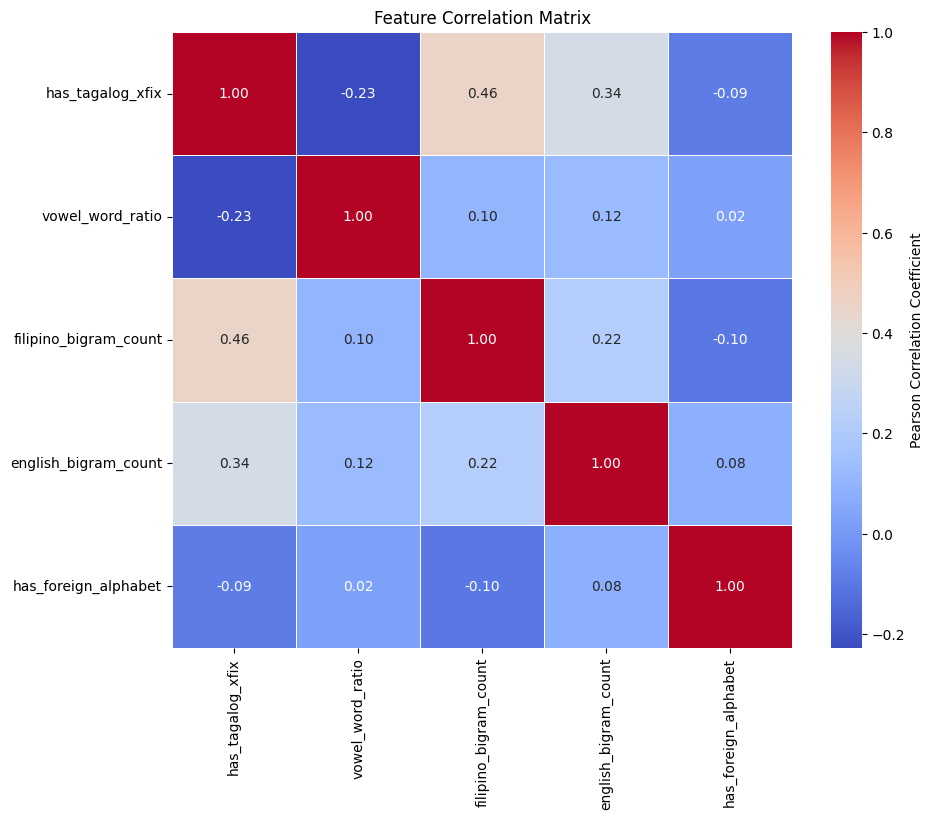

In [12]:
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm',
    linewidths=.5,
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)
plt.title('Feature Correlation Matrix')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

## Split the dataset to 15% test size and 85% train and validation size
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Split the train and validation set to 15% validation size and 85% train size
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

print("X_train: ",  len(X_train))
print("X_val: ", len(X_val))
print("y_train: ", len(y_train))
print("y_val: ", len(y_val))

X_train:  15005
X_val:  3217
y_train:  15005
y_val:  3217


Imbalance Data:

Check these techniques in imblearn library:
 - SMOTE
 - Undersampling
 - Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE


smote_sampler = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote_sampler.fit_resample(
    X_train, 
    y_train
)
print("Original training set size:", len(y_train))
print("Resampled training set size:", len(y_train_resampled))

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("Original training set size", len(y_train))
print(len((y_train_resampled)))

Original training set size 15005
37080


In [ ]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=42)

X_train_resampled, y_train_resampled = cc.fit_resample(X_train, y_train)

print("Original training set size", len(y_train))
print(len((y_train_resampled)))


ML Modelling

ML Modelling

Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)

y_val_pred = nb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Set Accuracy: {val_accuracy:.4f}")

## Hypertune by changing model parameters if needed (var_smoothing for GaussianNB)


In [ ]:
nb_model = GaussianNB(var_smoothing=np.float64(0.0001873817422860383))
nb_model.fit(X_train_resampled, y_train_resampled)

y_val_pred = nb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Set Accuracy: {val_accuracy:.4f}")

## Hypertune by changing model parameters if needed (var_smoothing for GaussianNB)


In [ ]:
# Hypertuned model
import numpy as np
from sklearn.model_selection import GridSearchCV

# ... (assume X_train, y_train, and cv_method are defined) ...

# Define the parameter grid
params_NB = {'var_smoothing': np.logspace(0, -9, num=100)}

# Initialize GridSearchCV
gs_NB = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=params_NB,
    verbose=1,
    scoring='accuracy'
)

# Fit the model to find the best parameter
gs_NB.fit(X_train, y_train)

# Print the best parameter found
print(gs_NB.best_params_)

Decision Trees

In [15]:
from sklearn import tree
from sklearn.metrics import accuracy_score

X_train_array = np.array(X_train_resampled)

# clf = tree.DecisionTreeClassifier(splitter='random')
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=1, min_samples_split=10)
clf = clf.fit(X_train_array, y_train_resampled)

y_val_pred = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Set Accuracy: {val_accuracy:.4f}")



Validation Set Accuracy: 0.9388


/Users/ejmasuncion/Desktop/Acads/CSC613M/pinoy_bot/pinoybotenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# Hypertuned model
from sklearn.model_selection import GridSearchCV

# ... (assume X_train, y_train, and cv_method are defined) ...

# Define the parameter grid
params_DT = {
    'criterion': ['gini', 'entropy'], # How to measure the quality of a split
    'max_depth': [3, 5, 7, 10, None], # Maximum depth of the tree (None means unlimited)
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4] # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV
gs_DF = GridSearchCV(
    estimator=clf,
    param_grid=params_DT,
    verbose=1,
    scoring='accuracy'
)

# Fit the model to find the best parameter
gs_DF.fit(X_train, y_train)

# Print the best parameter found
print(gs_DF.best_params_)

Model Validation:
- Confusion Matrix
- Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


y_test_pred = nb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Set Accuracy: **{test_accuracy:.4f}**")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Naive Bayes Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


y_test_pred = nb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Set Accuracy: **{test_accuracy:.4f}**")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Naive Bayes Confusion Matrix")
plt.show()

/Users/ejmasuncion/Desktop/Acads/CSC613M/pinoy_bot/pinoybotenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Test Set Accuracy: **0.9341**

Classification Report:
              precision    recall  f1-score   support

         ENG       0.57      0.72      0.64       257
         FIL       0.97      0.95      0.96      2652
         OTH       0.99      0.99      0.99       307

    accuracy                           0.93      3216
   macro avg       0.85      0.89      0.86      3216
weighted avg       0.94      0.93      0.94      3216



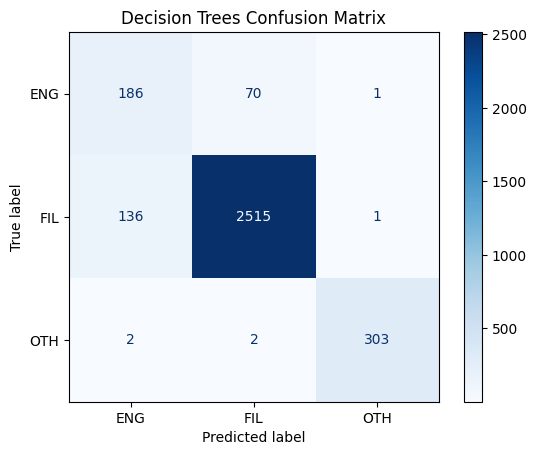

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Set Accuracy: **{test_accuracy:.4f}**")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

label = ['ENG', 'FIL', 'OTH']

cm = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Trees Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Set Accuracy: **{test_accuracy:.4f}**")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

label = ['ENG', 'FIL', 'OTH']

cm = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Trees Confusion Matrix")
plt.show()

In [17]:
import pickle    
filename = 'my_model.pkl'  # Choose a descriptive filename
with open(filename, 'wb') as file:
    pickle.dump(clf, file)

Decision Tree Feature Importance

In [19]:
importances = clf.feature_importances_

# Create a Series for easy viewing
feature_importance = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

print("## Feature Importance Scores (Top 5)")
print(feature_importance.head(10))

## Feature Importance Scores (Top 5)
vowel_word_ratio         0.625911
filipino_bigram_count    0.172452
has_foreign_alphabet     0.149360
english_bigram_count     0.031211
has_tagalog_xfix         0.021067
dtype: float64


<Figure size 800x600 with 0 Axes>

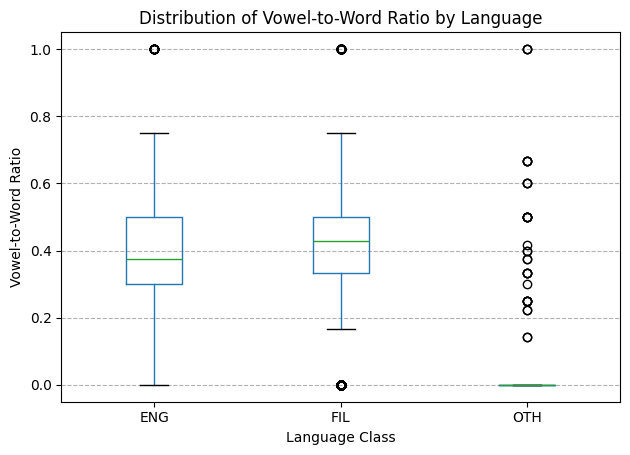

In [21]:
plt.figure(figsize=(8, 6))

df.boxplot(column='vowel_word_ratio', by='label', grid=False)
plt.suptitle('') 
plt.title('Distribution of Vowel-to-Word Ratio by Language')
plt.xlabel('Language Class')
plt.ylabel('Vowel-to-Word Ratio')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:

misclassified_mask = (y_test != y_test_pred)


error_analysis_df = pd.DataFrame({
    'Word': X_test[misclassified_mask],
    'True_Label': y_test[misclassified_mask],
    'Predicted_Label': y_test_pred[misclassified_mask]
})

print("## ❌ Words Misclassified by Decision Tree Model")
print(f"Total Errors Found: {len(error_analysis_df)}")
print("-" * 40)
print(error_analysis_df)

/var/folders/gh/8lb8pmm54lv62czj5v_yrmy00000gn/T/ipykernel_23412/2179082177.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'Word': df[misclassified_mask],


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [30]:
misclassified_mask = (y_test != y_test_pred)

misclassified_series = X_test[misclassified_mask]
misclassified_indexes = misclassified_series.index.tolist()

print("## 📝 List of Misclassified Sample Indexes")
print(misclassified_indexes)
# print(X_test[misclassified_mask])

## 📝 List of Misclassified Sample Indexes
[22719, 16901, 4307, 21189, 23111, 15720, 21673, 16463, 20082, 8342, 16716, 8286, 1389, 1623, 16432, 17492, 7082, 20819, 5117, 17555, 4089, 13989, 13811, 6027, 19164, 21388, 20447, 1772, 14435, 2689, 10182, 10049, 3753, 16197, 3773, 22694, 6650, 13378, 2535, 4780, 6360, 14323, 16020, 16223, 17273, 22613, 17088, 20404, 6508, 14939, 7302, 6994, 20832, 16253, 15532, 337, 4166, 3685, 12943, 6967, 8862, 16797, 4851, 15192, 2411, 2457, 20865, 18682, 13260, 8382, 8607, 18576, 4581, 23005, 23055, 6020, 20254, 7935, 9974, 7991, 367, 1575, 18139, 2714, 17902, 4498, 13045, 9567, 22589, 12702, 13641, 15994, 10184, 15511, 10148, 19036, 7443, 16121, 19198, 17049, 12581, 15367, 15894, 19248, 6294, 11193, 6900, 2775, 21944, 3362, 12128, 8720, 19439, 17499, 4248, 11963, 11400, 13573, 22811, 10063, 15530, 17185, 9575, 14963, 19453, 19660, 9722, 710, 9568, 2491, 5811, 11908, 13029, 21540, 10181, 21243, 2282, 1552, 8701, 5667, 5836, 12051, 20593, 19648, 13086, 178

In [ ]:
def analyze_misclassified_words(df, y_test, y_test_pred, misclassified_indexes):
    y_test_pred_series = pd.Series(y_test_pred, index=y_test.index)
    misclassified_df = df.loc[misclassified_indexes].copy()
    misclassified_df['true_label'] = y_test.loc[misclassified_indexes]
    misclassified_df['predicted_label'] = y_test_pred_series.loc[misclassified_indexes]

    final_analysis_df = misclassified_df[['word', 'true_label', 'predicted_label']]
    
    return final_analysis_df

# --- Example of How to Call the Function ---
final_misclassified_df = analyze_misclassified_words(df, y_test, y_test_pred, misclassified_indexes)

In [35]:
final_misclassified_df.to_csv('misclassified_words.csv', index=False)

In [ ]:
classified_mask = (y_test == y_test_pred)

classified_series = X_test[classified_mask]
classified_indexes = classified_series.index.tolist()

def analyze_classified_words(df, y_test, y_test_pred, classified_indexes):
    y_test_pred_series = pd.Series(y_test_pred, index=y_test.index)
    classified_df = df.loc[classified_indexes].copy()
    classified_df['true_label'] = y_test.loc[classified_indexes]
    classified_df['predicted_label'] = y_test_pred_series.loc[classified_indexes]

    final_analysis_df = classified_df[['word', 'true_label', 'predicted_label']]
    
    return final_analysis_df

# --- Example of How to Call the Function ---
final_classified_df = analyze_misclassified_words(df, y_test, y_test_pred, classified_indexes)

final_classified_df.to_csv('classified_words.csv', index=False)
